# Random Forest & Neural Net

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
from sklearn import ensemble
from sklearn import neural_network
import sklearn.tree
%matplotlib inline 

### Load in data

In [2]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/80_20_processed_data/master_8020_df.csv',index_col=0)

In [3]:
data.head(5)

Previous_10_Left_Choice  Previous_10_Right_Choice  Previous_10_Left_Reward  \
0                     10.0                       0.0                      8.0   
1                     10.0                       0.0                      7.0   
2                      9.0                       1.0                      6.0   
3                      8.0                       2.0                      5.0   
4                      8.0                       2.0                      5.0   

   Previous_10_Right_Reward  Streak  5_Port  5_Reward  5_ITI  5_trialDuration  \
0                       0.0    -1.0     1.0       0.0  3.286            0.407   
1                       0.0    -2.0     1.0       1.0  2.405            0.463   
2                       0.0    -3.0     1.0       1.0  2.379            0.367   
3                       0.0    -4.0     1.0       1.0  2.234            0.325   
4                       0.0     1.0     1.0       0.0  2.133            0.482   

   4_Port    ...     2_Reward  2_ITI  2_trialDuration  1_Port  1_Reward  \
0     1.0    ...          1.0  2.234            0.325     1.0       0.0   
1     1.0    ...          0.0  2.133            0.482     1.0       0.0   
2     1.0    ...          0.0  1.411            0.435     0.0       0.0   
3     1.0    ...          0.0  2.169            0.395     0.0       0.0   
4     1.0    ...          0.0  3.838            0.469     1.0       1.0   

   1_ITI  1_trialDuration  0_ITI  0_trialDuration  Decision  
0  2.133            0.482  1.411            0.435       1.0  
1  1.411            0.435  2.169            0.395       0.0  
2  2.169            0.395  3.838            0.469       0.0  
3  3.838            0.469  1.846            0.378       1.0  
4  1.846            0.378  1.527            0.416       1.0  

[5 rows x 28 columns]

In [4]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

### Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [5]:
y_diff = np.diff(y)
x = x[1:,:]
y = np.abs(y_diff.copy())

print(x.shape)
print(y_diff.shape)

(11325, 27)
(11325,)


### Split into training and testing set

In [6]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [7]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 7927 | # switches: 618 --> 7.8 percent
# test trials: 3398 | # switches: 279 --> 8.2 percent


# Random Forest



In [8]:
rf = ensemble.RandomForestClassifier(n_estimators = 10,criterion='gini',max_features='sqrt',class_weight={0:0.07,1:0.93})
rf.fit(x_train,y_train)
y_predict = rf.predict(x_test)

In [9]:
acc_pos,acc_neg,F1_k = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         3071.0           48.0
True YES         249.0           30.0

F1: 0.168

Accuracy on class 0: 0.98
Accuracy on class 1: 0.11



In [10]:
features = data.columns.values[:-1]
P = np.arange(0.5,1.0,0.01)
D = np.arange(1,20)
F1,w = np.zeros(D.shape[0]),np.zeros(D.shape[0])

for i,d in enumerate(D):
    
    for p in P:
        prior = np.array([1.0-p,p])
        rf = ensemble.RandomForestClassifier(n_estimators = 10,max_depth=d,max_features='sqrt',class_weight={0:prior[0],1:prior[1]})

        kf = model_selection.KFold(n_splits=3)
        cum_F1 = 0.0

        for train_index,test_index in kf.split(x_train):
            x_train_cv = x_train[train_index,:]
            y_train_cv = y_train[train_index]
            x_test_cv = x_train[test_index,:]
            y_test_cv = y_train[test_index]

            rf.fit(x_train_cv,y_train_cv)
            y_predict = rf.predict(x_test_cv)

            acc_pos,acc_neg,F1_k = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

            cum_F1 += F1_k

        F1_cv = cum_F1 / 3.0
    
        if F1_cv > F1[i]:
            F1[i] = F1_cv
            w[i] = p

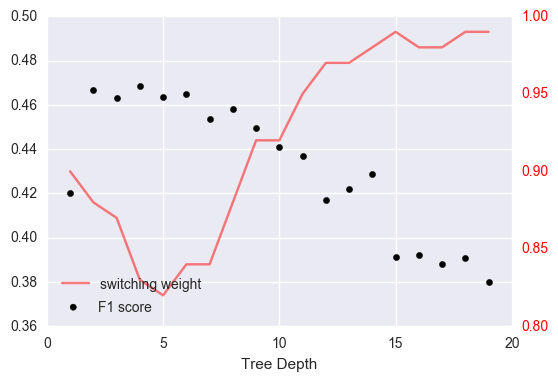

In [11]:
fig,ax1 = plt.subplots()
ax1.scatter(D,F1,color='black',label='F1 score')
ax1.set_xlabel('Tree Depth')
plt.legend(loc='lower left')

ax2 = ax1.twinx()
ax2.plot(D,w,color='red',alpha=0.5,label='switching weight')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.grid('off')
ax2.set_ylim(0.8,1)

plt.legend(bbox_to_anchor = (0.36,0.2))

In [24]:
rf = ensemble.RandomForestClassifier(n_estimators = 10,max_depth=4,max_features='sqrt',class_weight={0:0.14,1:0.86})
rf.fit(x_train,y_train)
y_predict = rf.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         2702.0          417.0
True YES          56.0          223.0

F1: 0.485

Accuracy on class 0: 0.87
Accuracy on class 1: 0.80



This is maybe doing a little better than our single models, but not by much. 

# Neural Net

In [13]:
mlp = neural_network.MLPClassifier()
mlp.fit(x_train,y_train)
y_predict = mlp.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         3060.0           59.0
True YES         209.0           70.0

F1: 0.343

Accuracy on class 0: 0.98
Accuracy on class 1: 0.25

